In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import linearmodels as lm
import matplotlib
import math
import statsmodels.formula.api as smf
import statsmodels.api as sm

from linearmodels.panel import PanelOLS
from linearmodels.panel import RandomEffects
from linearmodels.panel import FirstDifferenceOLS
from linearmodels.panel import compare
from matplotlib import pyplot as plt

from pandas.api.types import is_numeric_dtype

pd.set_option('display.max_columns', 500)

%matplotlib inline

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# read the main data set
df=pd.read_csv('estimation_file.csv',
                    encoding='utf-8')


C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (139,140,148) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# read in and join the maintenance and restructure data
mr=pd.read_csv('maintenance_restructure.csv',
                    encoding='utf-8')
mr = mr[['CBSA', 'Mode', 'Year', 'MAINTENANCE', 'MAINTENANCE_NYC', 'MAINTENANCE_WMATA', 'RESTRUCTURE']]

df = df.merge(mr, on=['CBSA', 'Mode', 'Year'], how='left')

In [4]:
# exclude if ridership is zero--missing data
df = df[df['UPT_ADJ']>0]

In [5]:
# exclude problematic data
old_len = len(df)
df = df[df['VRM_ADJ']>0]
new_len = len(df)
print('Excluding ' + str(old_len-new_len) + ' records with missing VRM') 

# exclude problematic data
old_len = len(df)
df = df[df['FARE_per_UPT_2018']>0]
new_len = len(df)
print('Excluding ' + str(old_len-new_len) + ' records with zero or negative fare') 

# exclude problematic data
old_len = len(df)
df = df[df['FARE_per_UPT_2018']<20]
new_len = len(df)
print('Excluding ' + str(old_len-new_len) + ' records with fare greater than $20') 

# exclude problematic data
old_len = len(df)
df = df[df['HH_0Veh']>0]
new_len = len(df)
print('Excluding ' + str(old_len-new_len) + ' records with negative 0 veh HH') 


Excluding 3 records with missing VRM
Excluding 108 records with zero or negative fare
Excluding 66 records with fare greater than $20
Excluding 27 records with negative 0 veh HH


In [6]:
# exclude discontinuous data
df = df.sort_values(by=['CBSA', 'Mode', 'Year'])

excluded_records = 100
while excluded_records > 0: 
    old_len = len(df)
    df['YearDiff'] = df['Year'].shift(-1) - df['Year']
    df = df[(df['YearDiff']==1) | (df['Year']==2018)]
    excluded_records = old_len - len(df)
    print('Excluding ' + str(excluded_records) + ' records with discontinuities in year.') 



Excluding 28 records with discontinuities in year.
Excluding 23 records with discontinuities in year.
Excluding 19 records with discontinuities in year.
Excluding 14 records with discontinuities in year.
Excluding 9 records with discontinuities in year.
Excluding 8 records with discontinuities in year.
Excluding 6 records with discontinuities in year.
Excluding 6 records with discontinuities in year.
Excluding 6 records with discontinuities in year.
Excluding 4 records with discontinuities in year.
Excluding 3 records with discontinuities in year.
Excluding 2 records with discontinuities in year.
Excluding 2 records with discontinuities in year.
Excluding 2 records with discontinuities in year.
Excluding 2 records with discontinuities in year.
Excluding 1 records with discontinuities in year.
Excluding 0 records with discontinuities in year.


In [7]:
df['BUS_FLAG'] = np.where(df['Mode']=='Bus', 1, 0)
df['RAIL_FLAG'] = np.where(df['Mode']=='Rail', 1, 0)

In [8]:
# include population + employment
df['POP_EMP'] = df['Tot_Pop'] + df['TOT_EMP_MSA']
df['HH_EMP'] = df['Total_HH'] + df['TOT_EMP_MSA']

# percent of population in transit supportive density
df['TSD_POP_PCT'] = df['POP_CENSUSTRACT'] / df['Tot_Pop']

# percent of pop born outside USA
df['Tot_NonUSA_POP_pct'] = df['Tot_NonUSA_POP'] / df['Tot_Pop'] * 100


In [9]:
# mode specific effects

df['Bus_VRM_ADJ_RAIL']  = df['Bus_VRM_ADJ'] * df['RAIL_FLAG']
df['Rail_VRM_ADJ_BUS'] = df['Rail_VRM_ADJ']  * df['BUS_FLAG']

df['Bus_VRM_ADJ_RAIL_log'] = np.log(1+df['Bus_VRM_ADJ_RAIL'])
df['Rail_VRM_ADJ_BUS_log'] = np.log(1+df['Rail_VRM_ADJ_BUS'])


In [10]:
# time effects
df['YEARS_SINCE_2002']  = df['Year'] - 2002

df['YEARS_2002_2010']  = df['Year'].apply(lambda x : min(x-2002, 8))
df['YEARS_AFTER_2010'] = df['Year'].apply(lambda x : max(x-2010, 0))

df['YEARS_2002_2014']  = df['Year'].apply(lambda x : min(x-2002, 12))
df['YEARS_AFTER_2014'] = df['Year'].apply(lambda x : max(x-2014, 0))


df['YEARS_SINCE_2002_BUS']  = df['YEARS_SINCE_2002'] * df['BUS_FLAG']
df['YEARS_SINCE_2002_RAIL'] = df['YEARS_SINCE_2002'] * df['RAIL_FLAG']

df['YEARS_2002_2010_BUS']   = df['YEARS_2002_2010'] * df['BUS_FLAG']
df['YEARS_AFTER_2010_BUS']  = df['YEARS_AFTER_2010']* df['BUS_FLAG']
df['YEARS_2002_2010_RAIL']  = df['YEARS_2002_2010'] * df['RAIL_FLAG']
df['YEARS_AFTER_2010_RAIL'] = df['YEARS_AFTER_2010']* df['RAIL_FLAG']

df['YEARS_2002_2014_BUS']   = df['YEARS_2002_2014'] * df['BUS_FLAG']
df['YEARS_AFTER_2014_BUS']  = df['YEARS_AFTER_2014']* df['BUS_FLAG']
df['YEARS_2002_2014_RAIL']  = df['YEARS_2002_2014'] * df['RAIL_FLAG']
df['YEARS_AFTER_2014_RAIL'] = df['YEARS_AFTER_2014']* df['RAIL_FLAG']

In [11]:
# test rail ramp up period
df['YEARS_SINCE_RAIL_START'] = (df['Year'] - df['min_year']) * df['RAIL_FLAG']
df['YEARS_SINCE_RAIL_START'] = np.where(df['min_year']==2002, 0, df['YEARS_SINCE_RAIL_START'])

df['YEARS_SINCE_RAIL_START_1'] = df['YEARS_SINCE_RAIL_START'].apply(lambda x : min(x, 1))
df['YEARS_SINCE_RAIL_START_2'] = df['YEARS_SINCE_RAIL_START'].apply(lambda x : min(x, 2))
df['YEARS_SINCE_RAIL_START_3'] = df['YEARS_SINCE_RAIL_START'].apply(lambda x : min(x, 3))



In [12]:
# calculate bus vs rail stuff

# various bus/rail specifics

df['TNC_FLAG_BUS'] = df['TNC_FLAG'] * df['BUS_FLAG']
df['TNC_FLAG_RAIL'] = df['TNC_FLAG'] * df['RAIL_FLAG']

df['YEARS_SINCE_TNC_BUS'] = df['YEARS_SINCE_TNC'] * df['BUS_FLAG']
df['YEARS_SINCE_TNC_RAIL'] = df['YEARS_SINCE_TNC'] * df['RAIL_FLAG']

df['dockless_flag'] = df['dockCt'].apply(lambda x : min(x,1))
df['scooter_flag']  = df['scooterCt'].apply(lambda x : min(x,1))

df['BIKE_SHARE'] = df['PBS_Flag'] + df['dockless_flag']
df['BIKE_SHARE'] = df['BIKE_SHARE'].apply(lambda x : min(x,1))


df['PBS_Flag_BUS']   = df['PBS_Flag']   * df['BUS_FLAG']
df['dockCt_BUS']     = df['dockCt']     * df['BUS_FLAG']
df['docklessCt_BUS'] = df['docklessCt'] * df['BUS_FLAG']
df['scooterCt_BUS']  = df['scooterCt']  * df['BUS_FLAG']
df['dockless_flag_BUS'] = df['dockless_flag'] * df['BUS_FLAG']
df['scooter_flag_BUS']  = df['scooter_flag']  * df['BUS_FLAG']
df['BIKE_SHARE_BUS']  = df['BIKE_SHARE']  * df['BUS_FLAG']


df['PBS_Flag_RAIL']   = df['PBS_Flag']   * df['RAIL_FLAG']
df['dockCt_RAIL']     = df['dockCt']     * df['RAIL_FLAG']
df['docklessCt_RAIL'] = df['docklessCt'] * df['RAIL_FLAG']
df['scooterCt_RAIL']  = df['scooterCt']  * df['RAIL_FLAG']
df['dockless_flag_RAIL'] = df['dockless_flag'] * df['RAIL_FLAG']
df['scooter_flag_RAIL']  = df['scooter_flag']  * df['RAIL_FLAG']
df['BIKE_SHARE_RAIL']  = df['BIKE_SHARE']  * df['RAIL_FLAG']




In [13]:
# convert JTW to numeric columns
df['JTW_DA_PCT']        = df['JTW_DA_PCT'].astype(float)
df['JTW_CARPOOLED_PCT'] = df['JTW_CARPOOLED_PCT'].astype(float)
df['JTW_TRANSIT_PCT']   = df['JTW_TRANSIT_PCT'].astype(float)
df['JTW_WALK_PCT']      = df['JTW_WALK_PCT'].astype(float)
df['JTW_BICYCLE_PCT']   = df['JTW_BICYCLE_PCT'].astype(float)
df['JTW_OTHER_PCT']     = df['JTW_OTHER_PCT'].astype(float)
df['JTW_HOME_PCT']      = df['JTW_HOME_PCT'].astype(float)


In [15]:
# Calculate service cuts versus gains
df['VRM_CUT'] =np.where(df['Bus_VRM_ADJ_diff']<0, 1, 0)
df['VRM_CUT'] =np.where(df['Rail_VRM_ADJ_diff']<0, 1, df['VRM_CUT'])

df['VRM_ADJ_CUT']  = df['VRM_ADJ'] * df['VRM_CUT']
df['VRM_ADJ_GAIN'] = df['VRM_ADJ'] * (1-df['VRM_CUT'])

df['VRM_ADJ_LAGGED_1_CUT']  = df['VRM_ADJ_LAGGED_1'] * df['VRM_CUT']
df['VRM_ADJ_LAGGED_1_GAIN'] = df['VRM_ADJ_LAGGED_1'] * (1-df['VRM_CUT'])

df['VRM_ADJ_LAGGED_2_CUT']  = df['VRM_ADJ_LAGGED_2'] * df['VRM_CUT']
df['VRM_ADJ_LAGGED_2_GAIN'] = df['VRM_ADJ_LAGGED_2'] * (1-df['VRM_CUT'])

# calculate fare increase versus decrease
df['FARE_INCREASE'] =np.where(df['FARE_per_UPT_2018']>0, 1, 0)

df['FARE_per_UPT_INCREASE_2018']  = df['FARE_per_UPT_2018'] * df['FARE_INCREASE']
df['FARE_per_UPT_DECREASE_2018']  = df['FARE_per_UPT_2018'] * (1-df['FARE_INCREASE'])

df['FARE_per_UPT_INCREASE_2018_LAGGED_1']  = df['FARE_per_UPT_2018_LAGGED_1'] * df['FARE_INCREASE']
df['FARE_per_UPT_DECREASE_2018_LAGGED_1']  = df['FARE_per_UPT_2018_LAGGED_1'] * (1-df['FARE_INCREASE'])

df['FARE_per_UPT_INCREASE_2018_LAGGED_2']  = df['FARE_per_UPT_2018_LAGGED_2'] * df['FARE_INCREASE']
df['FARE_per_UPT_DECREASE_2018_LAGGED_2']  = df['FARE_per_UPT_2018_LAGGED_2'] * (1-df['FARE_INCREASE'])


In [17]:
# immigrant population percentage
df['Tot_NonUSA_POP_pct'] = df['Tot_NonUSA_POP'] / df['Tot_Pop'] * 100

# include VRM on competing modes -- split
df['VRM_ADJ_COMPETING_BUS']  = df['VRM_ADJ_COMPETING'] * df['RAIL_FLAG']
df['VRM_ADJ_COMPETING_RAIL'] = df['VRM_ADJ_COMPETING'] * df['BUS_FLAG']

# include VRM on competing modes -- split
df['VRM_ADJ_COMPETING_BUS']  = df['VRM_ADJ_COMPETING'] * df['RAIL_FLAG']
df['VRM_ADJ_COMPETING_RAIL'] = df['VRM_ADJ_COMPETING'] * df['BUS_FLAG']

# flag testing introduction of new rail
df['RAIL_COMPETITION'] = np.where(df['VRM_ADJ_COMPETING']>0, 1, 0) * df['BUS_FLAG']



In [18]:
# TNC lags -- bus vs rail
df['TNC_FLAG_BUS_LAGGED_1'] = df['TNC_FLAG_LAGGED_1'] * df['BUS_FLAG']
df['TNC_FLAG_BUS_LAGGED_2'] = df['TNC_FLAG_LAGGED_2'] * df['BUS_FLAG']
df['TNC_FLAG_BUS_LAGGED_3'] = df['TNC_FLAG_LAGGED_3'] * df['BUS_FLAG']

df['TNC_FLAG_RAIL_LAGGED_1'] = df['TNC_FLAG_LAGGED_1'] * df['RAIL_FLAG']
df['TNC_FLAG_RAIL_LAGGED_2'] = df['TNC_FLAG_LAGGED_2'] * df['RAIL_FLAG']
df['TNC_FLAG_RAIL_LAGGED_3'] = df['TNC_FLAG_LAGGED_3'] * df['RAIL_FLAG']

# bike share plus scooters for rail
df['BIKE_SCOOTER_RAIL'] = df['BIKE_SHARE_RAIL'] + df['scooter_flag_RAIL']

# different spec of bike and scooter
df['BIKE_SCOOTER_SCOOTER_RAIL'] = df['BIKE_SHARE_RAIL'] + df['scooter_flag_RAIL'] + df['scooter_flag_RAIL']

# different spec of bike and scooter
df['BIKE_SCOOTER_SCOOTER_RAIL'] = df['BIKE_SHARE_RAIL'] + df['scooter_flag_RAIL'] + df['scooter_flag_RAIL']

# merge bike and scooter for bus
df['BIKE_SCOOTER_SCOOTER_BUS'] = df['BIKE_SHARE_BUS'] + df['scooter_flag_BUS'] + df['scooter_flag_BUS']

# merge bike and scooter for bus
df['BIKE_SCOOTER_BUS'] = df['BIKE_SHARE_BUS'] + df['scooter_flag_BUS'] 
df['BIKE_SCOOTER_RAIL'] = df['BIKE_SHARE_RAIL'] + df['scooter_flag_RAIL'] 

# scooter or bike
df['BIKE_OR_SCOOTER_BUS']  = df['BIKE_SHARE_BUS'] + df['scooter_flag_BUS'] 
df['BIKE_OR_SCOOTER_BUS']  = df['BIKE_OR_SCOOTER_BUS'].apply(lambda x : min(x, 1))

df['BIKE_OR_SCOOTER_RAIL'] = df['BIKE_SHARE_RAIL'] + df['scooter_flag_RAIL'] 
df['BIKE_OR_SCOOTER_RAIL'] = df['BIKE_OR_SCOOTER_RAIL'].apply(lambda x : min(x, 1))

# calculate average vehicles
df['AVG_VEHS'] = (df['HH_1Veh'] + 2*df['HH_2Veh'] + 3*df['HH_3Veh'] + 4*df['HH_4+Veh']) / (df['HH_0Veh'] + df['HH_1Veh'] + df['HH_2Veh'] + df['HH_3Veh'] + df['HH_4+Veh'])
df['AVG_VEHS_log'] = np.log(1+df['AVG_VEHS'])



In [19]:
# walk bike other commuting
df['JTW_WALK_BIKE_OTHER_PCT'] = df['JTW_WALK_PCT'] + df['JTW_BICYCLE_PCT'] + df['JTW_OTHER_PCT']

# walk bike commuting
df['JTW_WALK_BIKE_PCT'] = df['JTW_WALK_PCT'] + df['JTW_BICYCLE_PCT']


In [20]:
# set the indices
df['ID'] = df['MNAME'] + '-' + df['Mode']
df=df.set_index(['ID','Year'])

In [21]:
# keep only the numeric columns -- the estimation will give an error otherwise
df = df.select_dtypes(include=[np.number])

In [22]:
# create a log of all fields
for col in df.columns:
    df[col+'_log'] = np.log(df[col]+1)
    

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


## Model Estimation Tests

In [23]:
# fully specified model  

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4961
Estimator:                   PanelOLS   R-squared (Between):              0.9489
No. Observations:                3979   R-squared (Within):               0.4961
Date:                Fri, Dec 06 2019   R-squared (Overall):              0.9485
Time:                        11:44:56   Log-likelihood                    1292.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      227.89
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.304   Distribution:                 F(16,3703)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             227.89
                            

In [40]:
# fully specified model  

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SHARE_RAIL \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4967
Estimator:                   PanelOLS   R-squared (Between):              0.9513
No. Observations:                3979   R-squared (Within):               0.4967
Date:                Fri, Dec 06 2019   R-squared (Overall):              0.9509
Time:                        12:55:37   Log-likelihood                    1294.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      202.88
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.304   Distribution:                 F(18,3701)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             202.88
                            

In [32]:
# remove TNCs to see effect on bike share
# when we do this, the bike share and scooter variables become more negative
# this suggests that since both are happening at the same time, so it is difficult to 
# separate the effect of each.  

# the remaining coefficients are pretty stable, which is encouraging

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + MAINTENANCE_WMATA \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4919
Estimator:                   PanelOLS   R-squared (Between):              0.9189
No. Observations:                3979   R-squared (Within):               0.4919
Date:                Fri, Dec 06 2019   R-squared (Overall):              0.9186
Time:                        11:52:46   Log-likelihood                    1275.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      256.16
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.304   Distribution:                 F(14,3705)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             256.16
                            

In [33]:
# remove bike share to see the effect on TNCs
# when we do this, we see that the TNC variables don't change very much
# this suggests that the TNC terms are more stable/more important than the bike share terms. 

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4960
Estimator:                   PanelOLS   R-squared (Between):              0.9489
No. Observations:                3979   R-squared (Within):               0.4960
Date:                Fri, Dec 06 2019   R-squared (Overall):              0.9485
Time:                        11:53:51   Log-likelihood                    1291.9
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      260.45
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.304   Distribution:                 F(14,3705)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             260.45
                            

In [36]:
# simplified model
# drops rail ramp up, rail competition and maintenance

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4940
Estimator:                   PanelOLS   R-squared (Between):              0.9522
No. Observations:                3979   R-squared (Within):               0.4940
Date:                Fri, Dec 06 2019   R-squared (Overall):              0.9519
Time:                        11:56:02   Log-likelihood                    1284.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      278.37
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.304   Distribution:                 F(13,3706)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             278.37
                            

In [41]:
# model without maintenance

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SHARE_RAIL \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4962
Estimator:                   PanelOLS   R-squared (Between):              0.9517
No. Observations:                3979   R-squared (Within):               0.4962
Date:                Fri, Dec 06 2019   R-squared (Overall):              0.9513
Time:                        13:27:29   Log-likelihood                    1292.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      214.45
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.304   Distribution:                 F(17,3702)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             214.45
                            

In [42]:
# drop rail ramp up


mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SHARE_RAIL \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4958
Estimator:                   PanelOLS   R-squared (Between):              0.9526
No. Observations:                3979   R-squared (Within):               0.4958
Date:                Fri, Dec 06 2019   R-squared (Overall):              0.9523
Time:                        13:28:26   Log-likelihood                    1290.9
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      227.55
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.304   Distribution:                 F(16,3703)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             227.55
                            

## Run some analytics

In [43]:

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SHARE_RAIL \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4958
Estimator:                   PanelOLS   R-squared (Between):              0.9526
No. Observations:                3979   R-squared (Within):               0.4958
Date:                Fri, Dec 06 2019   R-squared (Overall):              0.9523
Time:                        13:30:11   Log-likelihood                    1290.9
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      227.55
Entities:                         260   P-value                           0.0000
Avg Obs:                       15.304   Distribution:                 F(16,3703)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             227.55
                            

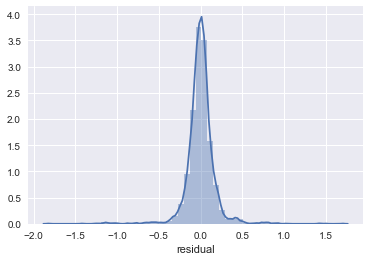

In [44]:
sns.distplot(res.resids)

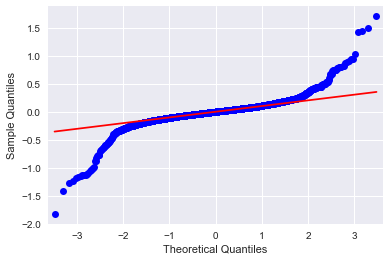

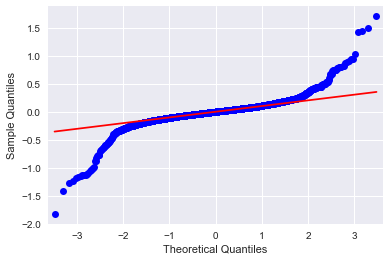

In [45]:
sm.graphics.qqplot(res.resids,line = 'q')

## Calculate FAC

In [47]:
# keep the relevant fields in the data set
app_data = pd.concat([df[['RAIL_FLAG', 'CLUSTER_APTA']], 
                      res.model.dependent.dataframe, 
                      res.model.exog.dataframe, 
                      res.estimated_effects, 
                      res.resids], axis=1)


In [48]:
app_data.head()

RAIL_FLAG  CLUSTER_APTA  UPT_ADJ_log  \
Akron, OH Metro Area-Bus 2002          0            24    15.469231   
                         2003          0            24    15.501150   
                         2004          0            24    15.591676   
                         2005          0            24    15.609548   
                         2006          0            24    15.619001   

                               VRM_ADJ_log  FARE_per_UPT_2018_log  \
Akron, OH Metro Area-Bus 2002    15.208377               0.568842   
                         2003    15.195930               1.362981   
                         2004    15.277699               1.247162   
                         2005    15.214971               1.355716   
                         2006    15.200501               1.356994   

                               POP_EMP_log  GAS_PRICE_2018_log  \
Akron, OH Metro Area-Bus 2002    13.808216            1.066089   
                         2003    13.823451            1.138954   
                         2004    13.839439            1.233697   
                         2005    13.857195            1.361617   
                         2006    13.879496            1.429114   

                               TOTAL_MED_INC_INDIV_2018_log  \
Akron, OH Metro Area-Bus 2002                     10.479210   
                         2003                     10.446267   
                         2004                     10.403980   
                         2005                     10.365663   
                         2006                     10.305856   

                               Tot_NonUSA_POP_pct  PCT_HH_NO_VEH  TSD_POP_PCT  \
Akron, OH Metro Area-Bus 2002           -0.060245           8.60     0.185260   
                         2003            0.114214           8.20     0.180770   
                         2004            0.288851           7.79     0.176377   
                         2005            0.430267           7.47     0.172435   
                         2006            0.669812           6.85     0.167543   

                               JTW_HOME_PCT  RAIL_COMPETITION  \
Akron, OH Metro Area-Bus 2002           3.1               0.0   
                         2003           3.1               0.0   
                         2004           3.1               0.0   
                         2005           3.1               0.0   
                         2006           2.5               0.0   

                               YEARS_SINCE_TNC_BUS  YEARS_SINCE_TNC_RAIL  \
Akron, OH Metro Area-Bus 2002                  0.0                   0.0   
                         2003                  0.0                   0.0   
                         2004                  0.0                   0.0   
                         2005                  0.0                   0.0   
                         2006                  0.0                   0.0   

                               BIKE_SHARE_BUS  scooter_flag_BUS  \
Akron, OH Metro Area-Bus 2002             0.0               0.0   
                         2003             0.0               0.0   
                         2004             0.0               0.0   
                         2005             0.0               0.0   
                         2006             0.0               0.0   

                               BIKE_SHARE_RAIL  scooter_flag_RAIL   effects  \
Akron, OH Metro Area-Bus 2002              0.0                0.0  3.255227   
                         2003              0.0                0.0  3.255227   
                         2004              0.0                0.0  3.255227   
                         2005              0.0                0.0  3.255227   
                         2006              0.0                0.0  3.255227   

                               residual  
Akron, OH Metro Area-Bus 2002 -0.194685  
                         2003  0.028133  
                         2004 -0.001868  
                         2005  0

In [49]:
# calculate the fitted values
app_data['fitted'] = app_data['effects']
for var in res.params.keys(): 
    app_data['fitted'] = app_data['fitted'] + (res.params[var] * app_data[var])

# and check that we add up correctly
app_data['check_fitted'] = app_data['fitted'] + app_data['residual'] - app_data['UPT_ADJ_log']

In [50]:
# create the necessary columns

# dependents
app_data['UPT_ADJ']    = np.exp(app_data['UPT_ADJ_log']) - 1
app_data['fitted_exp'] = np.exp(app_data['fitted']) - 1

# linear versions of logged variables
for var in res.params.keys(): 
    if '_log' in var: 
        app_data[var.replace('_log', '')] = np.exp(app_data[var]) - 1              

# ratios and differences
for var in res.params.keys(): 
    if '_log' in var: 
        app_data[var.replace('_log', '_ratio')] = 1
    else: 
        app_data[var+'_diff'] = 0

# FAC multipliers
for var in res.params.keys(): 
    app_data[var+'_FAC_ratio'] = 1

app_data['UPT_ADJ_base'] = 0
app_data['UPT_ADJ_ratio'] = 1
app_data['fitted_exp_ratio'] = 1
app_data['UPT_ADJ_diff'] = 0
app_data['fitted_exp_diff'] = 0

In [51]:
# calculate the FAC relative to a specific base year
ids = app_data.index.get_level_values(0).unique()

for id in ids: 
    years = app_data.loc[id].index.get_level_values(0)

    for year in years[1:]:       
        base_year = year-1
        
        for var in res.params.keys(): 
            # ratios and differences
            if '_log' in var: 
                out_var = var.replace('_log', '_ratio')
                app_data.loc[(id,year), out_var] = (app_data.loc[(id,year), var] 
                                                 / app_data.loc[(id,base_year), var])
            else: 
                out_var = var+'_diff'                    
                app_data.loc[(id,year), out_var] = (app_data.loc[(id,year), var] 
                                                 - app_data.loc[(id,base_year), var])

            # FAC multipliers
            app_data.loc[(id,year),var+'_FAC_ratio'] = np.exp(res.params[var] * (
                                                    app_data.loc[(id,year), var] 
                                                    - app_data.loc[(id,base_year), var]))

            # estimated effects (if time effects is zero, no change)
            app_data.loc[(id,year),'effects_FAC_ratio'] = np.exp(
                                                    app_data.loc[(id,year), 'effects'] 
                                                    - app_data.loc[(id,base_year), 'effects'])

            # residual
            app_data.loc[(id,year),'residual_FAC_ratio'] = np.exp(
                                                    app_data.loc[(id,year), 'residual'] 
                                                    - app_data.loc[(id,base_year), 'residual'])

        # observed and fitted changes            
        app_data.loc[(id,year),'UPT_ADJ_base'] = app_data.loc[(id,base_year),'UPT_ADJ']
        app_data.loc[(id,year),'UPT_ADJ_ratio'] = (app_data.loc[(id,year),'UPT_ADJ'] 
                                                 / app_data.loc[(id,base_year),'UPT_ADJ'])
        app_data.loc[(id,year),'fitted_exp_ratio'] = (app_data.loc[(id,year),'fitted_exp'] 
                                                 / app_data.loc[(id,base_year),'fitted_exp'])

        app_data.loc[(id,year),'UPT_ADJ_diff'] = (app_data.loc[(id,year),'UPT_ADJ'] 
                                                 - app_data.loc[(id,base_year),'UPT_ADJ'])
        app_data.loc[(id,year),'fitted_exp_diff'] = (app_data.loc[(id,year),'fitted_exp'] 
                                                 - app_data.loc[(id,base_year),'fitted_exp'])


In [52]:
# calculate the total change ratios

app_data['FAC_ratio'] = 1
for var in res.params.keys(): 
    app_data['FAC_ratio'] = app_data['FAC_ratio'] * app_data[var+'_FAC_ratio']
    
app_data['FAC_ratio'] = app_data['FAC_ratio'] * app_data['effects_FAC_ratio']

In [53]:
# calculate the FAC
app_data['Total_FAC'] = 0
for var in res.params.keys(): 
    app_data[var+'_FAC'] = (app_data[var+'_FAC_ratio'] - 1) * app_data['UPT_ADJ_base']
    app_data['Total_FAC'] = app_data['Total_FAC'] + app_data[var+'_FAC']
app_data['effects_FAC'] = (app_data['effects_FAC_ratio'] - 1) * app_data['UPT_ADJ_base']
app_data['Total_FAC'] = app_data['Total_FAC'] + app_data['effects_FAC']

# scale the FAC
app_data['FAC_scale'] = app_data['fitted_exp_diff'] / app_data['Total_FAC']
app_data['FAC_scale'] = app_data['FAC_scale'].fillna(1)

app_data['Total_FAC_scaled'] = 0
for var in res.params.keys(): 
    app_data[var+'_FAC_scaled'] = app_data[var+'_FAC'] * app_data['FAC_scale']
    app_data['Total_FAC_scaled'] = app_data['Total_FAC_scaled'] + app_data[var+'_FAC_scaled']
app_data['effects_FAC_scaled'] = app_data[var+'_FAC_scaled'] * app_data['FAC_scale']
app_data['Total_FAC_scaled'] = app_data['Total_FAC_scaled'] + app_data['effects_FAC_scaled']


In [54]:
# calculate APTA - 4 groups
app_data['CLUSTER_APTA4'] = np.floor(app_data['CLUSTER_APTA']/10)

In [55]:
# reset the index so I get ID and year
app_data = app_data.reset_index()
app_data = app_data.rename(columns={'level_0' : 'ID', 'level_1' : 'Year'})
app_data.to_csv('FAC.csv')

In [56]:
# these are the fields we keep
out_fields = ['ID', 'Year', 'RAIL_FLAG', 
              'CLUSTER_APTA', 'CLUSTER_APTA4', 
              'UPT_ADJ_base', 'UPT_ADJ', 'UPT_ADJ_diff', 
              'fitted_exp', 'fitted_exp_diff']

# exogenous variables 
for var in res.params.keys(): 
    out_var = var.replace('_log', '')
    out_fields = out_fields + [out_var]
    
# FAC
for var in res.params.keys(): 
    out_fields = out_fields + [var+'_FAC']
out_fields = out_fields + ['Total_FAC']
    
# scaled FAC
for var in res.params.keys(): 
    out_fields = out_fields + [var+'_FAC_scaled']
out_fields = out_fields + ['Total_FAC_scaled']

# keep those fields
summary_data = app_data.reset_index()[out_fields]

In [57]:
# take weighted average of exogenous variables
for var in res.params.keys(): 
    out_var = var.replace('_log', '')
    summary_data[out_var] = summary_data[out_var] * summary_data['UPT_ADJ_base']

# aggregate to bus/rail totals
summary_data_apta4 = summary_data.groupby(by=['CLUSTER_APTA4', 'RAIL_FLAG', 'Year']).agg('sum')

# divide for weighted averages
for var in res.params.keys(): 
    out_var = var.replace('_log', '')
#    summary_data_gt[out_var] = summary_data_gt[out_var] / summary_data_gt['UPT_ADJ_base']
    summary_data_apta4[out_var] = summary_data_apta4[out_var] / summary_data_apta4['UPT_ADJ_base']
#    summary_data_apta_hml[out_var] = summary_data_apta_hml[out_var] / summary_data_apta_hml['UPT_ADJ_base']
    

In [58]:
#summary_data_gt.to_csv('FAC_totals_GT_CLUSTERS.csv')
summary_data_apta4.to_csv('FAC_totals_APTA4_CLUSTERS.csv')
#summary_data_apta_hml.to_csv('FAC_totals_APTA_HML_CLUSTERS.csv')


In [59]:
summary_data_apta4.head(20)

CLUSTER_APTA  UPT_ADJ_base       UPT_ADJ  \
CLUSTER_APTA4 RAIL_FLAG Year                                             
1.0           0         2002           190  0.000000e+00  2.013179e+09   
                        2003           190  2.013179e+09  2.013821e+09   
                        2004           190  2.013821e+09  2.041333e+09   
                        2005           190  2.041333e+09  2.063005e+09   
                        2006           190  2.063005e+09  2.071799e+09   
                        2007           190  2.071799e+09  2.090532e+09   
                        2008           190  2.090532e+09  2.172421e+09   
                        2009           190  2.172421e+09  2.087737e+09   
                        2010           190  2.087737e+09  2.019401e+09   
                        2011           190  2.019401e+09  2.050938e+09   
                        2012           190  2.050938e+09  2.080704e+09   
                        2013           190  2.080704e+09  2.076741e+09   
                        2014           190  2.076741e+09  2.061719e+09   
                        2015           190  2.061719e+09  2.028750e+09   
                        2016           190  2.028750e+09  1.944705e+09   
                        2017           190  1.944705e+09  1.875434e+09   
                        2018           190  1.875434e+09  1.832288e+09   
              1         2002           140  0.000000e+00  1.217256e+09   
                        2003           140  1.217256e+09  1.210060e+09   
                        2004           160  1.210060e+09  1.282836e+09   

                              UPT_ADJ_diff    fitted_exp  fitted_exp_diff  \
CLUSTER_APTA4 RAIL_FLAG Year                                                
1.0           0         2002  0.000000e+00  1.850369e+09     0.000000e+00   
                        2003  6.425510e+05  1.974676e+09     1.243077e+08   
                        2004  2.751127e+07  2.025687e+09     5.101078e+07   
                        2005  2.167215e+07  2.069430e+09     4.374264e+07   
                        2006  8.794756e+06  2.134866e+09     6.543633e+07   
                        2007  1.873279e+07  2.162979e+09     2.811260e+07   
                        2008  8.188896e+07  2.242658e+09     7.967895e+07   
                        2009 -8.468456e+07  2.121451e+09    -1.212070e+08   
                        2010 -6.833532e+07  2.115997e+09    -5.453459e+06   
                        2011  3.153659e+07  2.149838e+09     3.384099e+07   
                        2012  2.976613e+07  2.120690e+09    -2.914797e+07   
                        2013 -3.963190e+06  2.078421e+09    -4.226893e+07   
                        2014 -1.502232e+07  2.040174e+09    -3.824715e+07   
                        2015 -3.296812e+07  1.928534e+09    -1.116397e+08   
                        2016 -8.404573e+07  1.854076e+09    -7.445821e+07   
                        2017 -6.927050e+07  1.853022e+09    -1.054039e+06   
                        2018 -4.314625e+07  1.819674e+09    -3.334826e+07   
              1         2002  0.000000e+00  1.121117e+09     0.000000e+00   
                        2003 -7.195719e+06  1.198814e+09     7.769716e+07   
                        2004  6.214108e+07  1.244323e+09     3.306124e+07   

                                   VRM_ADJ  FARE_per_UPT_2018       POP_EMP  \
CLUSTER_APTA4 RAIL_FLAG Year                                                  
1.0           0         2002           NaN                NaN           NaN   
                        2003  5.248391e+07           5.350668  7.061254e+06   
                        2004  5.326346e+07           5.466338  7.213577e+06   
                        2005  5.197083e+07           5.528897  7.409766e+06   
                        2006  5.206632e+07           5.485058  7.653103e+06   
                        2007  5.340645e+07           5.577975  7.706491e+06   
                        2008  5.411188e+07           5.445940  7.762979e+0